In [1]:
import pandas as pd, numpy as np
from matplotlib import pyplot as plt
from json import dump
from os import listdir
from math import ceil
from collections import defaultdict
from scipy.interpolate import interp1d as lerp

# Pan

## Primeiro teste (degrau/rampa)

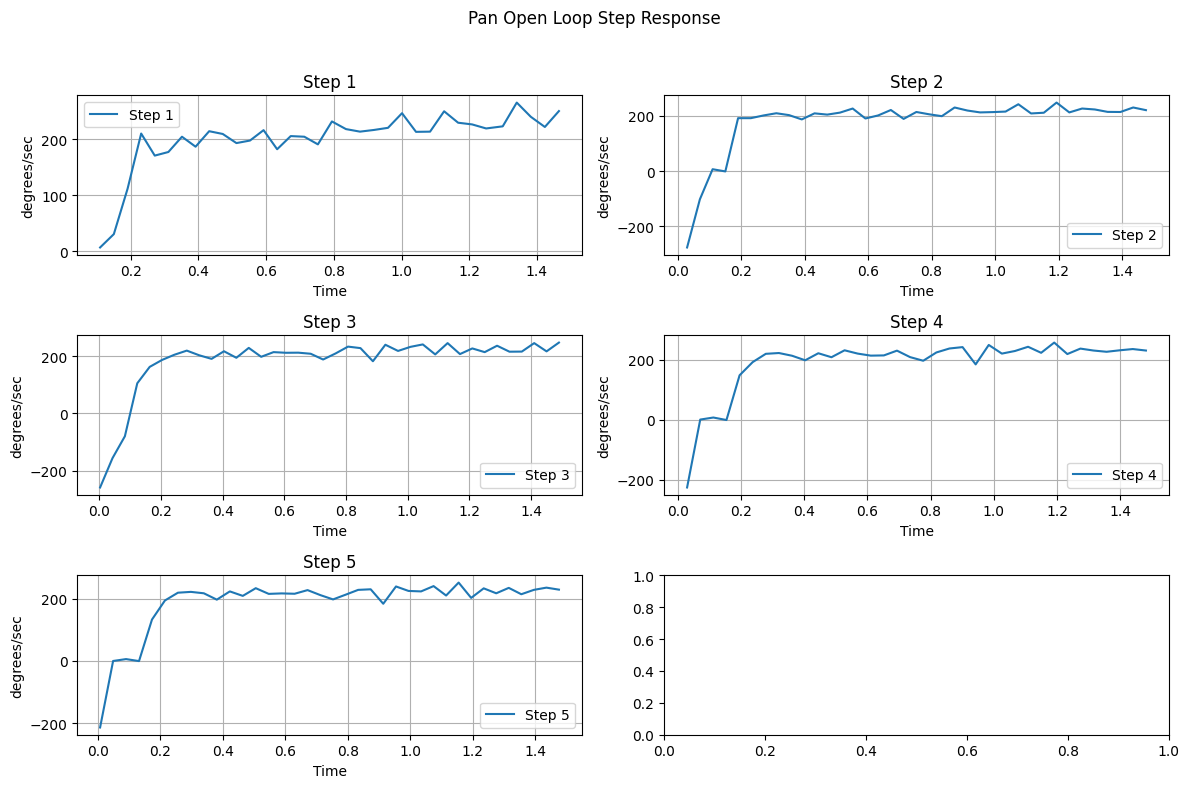

In [2]:
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
fig.suptitle('Pan Open Loop Step Response')

for i in range(1, 6):
    file_path = f'/home/nikolas/Documents/GitHub/Controller/logs/pan/{i}_step_open_loop PAN.csv'
    df = pd.read_csv(file_path).query("Tempo <= 1.5")
    row, col = divmod(i-1, 2)

    axs[row, col].plot(df['Tempo'], df['Saída'], label=f'Step {i}')
    axs[row, col].set_title(f'Step {i}')
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('degrees/sec')
    axs[row, col].legend()
    axs[row, col].grid(True)

plt.tight_layout(rect=(0, 0, 1, 0.96))

plt.show()

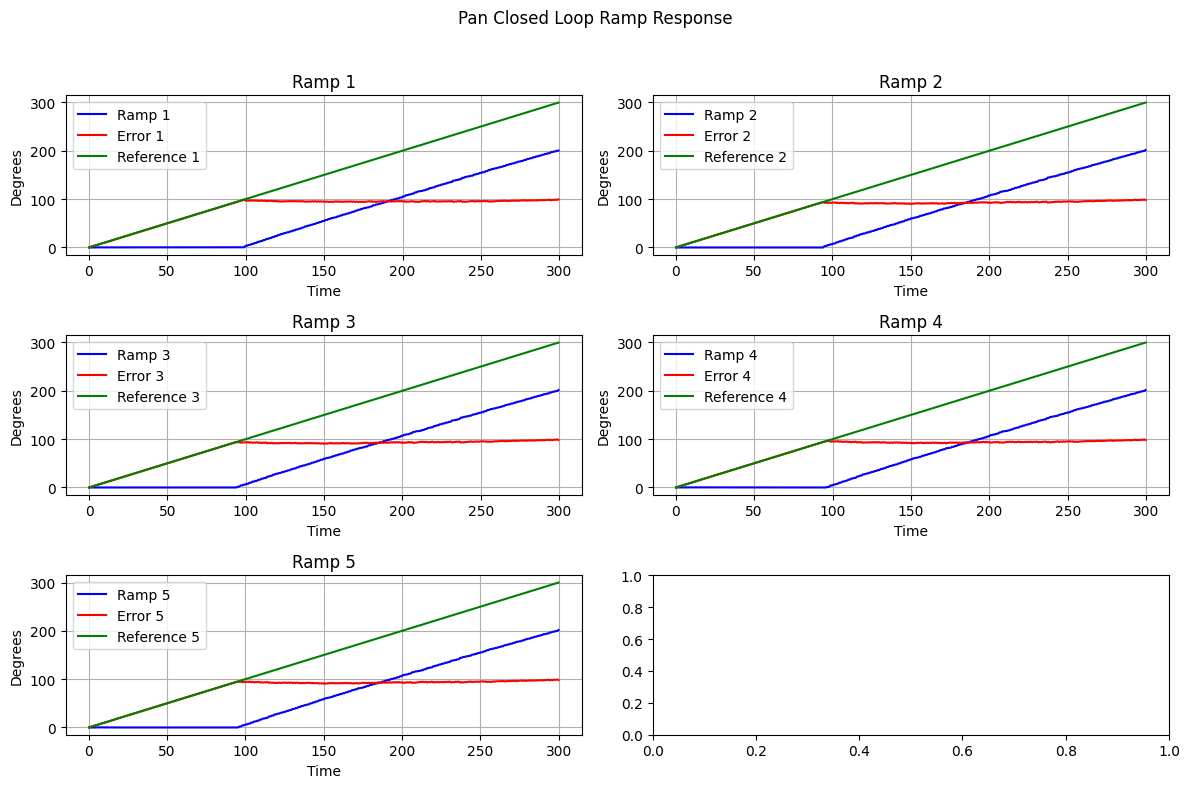

In [3]:
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
fig.suptitle('Pan Closed Loop Ramp Response')

for i in range(1, 6):
    file_path = f'/home/nikolas/Documents/GitHub/Controller/logs/pan/{i}_ramp_closed_loop PAN.csv'
    df = pd.read_csv(file_path).query("Referencia <= 300")
    row, col = divmod(i-1, 2)

    axs[row, col].plot(df['Referencia'], df['Saída'], c="b", label=f'Ramp {i}')
    axs[row, col].plot(df['Referencia'], df['Erro'], c="r", label=f"Error {i}")
    axs[row, col].plot(df['Referencia'], df['Referencia'], c="g", label=f"Reference {i}")
    axs[row, col].set_title(f'Ramp {i}')
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Degrees')
    axs[row, col].legend()
    axs[row, col].grid(True)

plt.tight_layout(rect=(0, 0, 1, 0.96))

plt.show()

## Segundo teste (degrau/rampa)

In [4]:
tau, ss_err = [], []

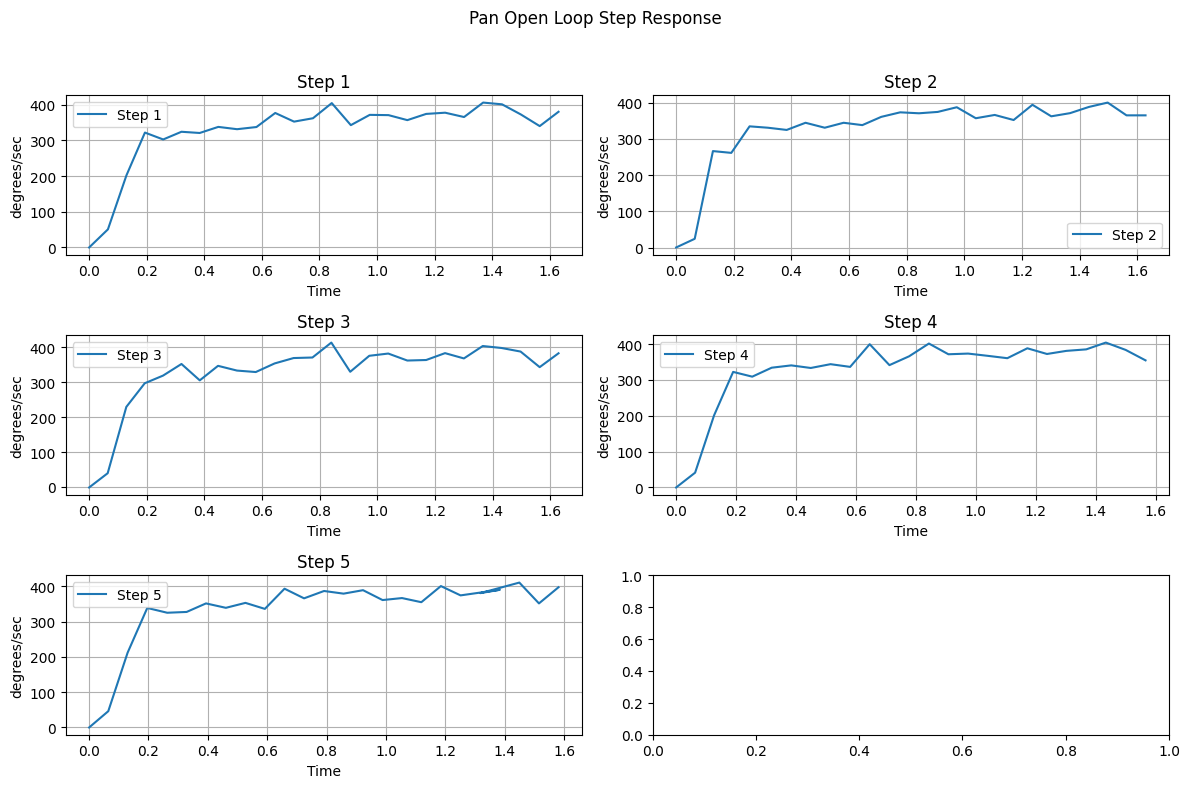

In [5]:
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
fig.suptitle('Pan Open Loop Step Response')

for i in range(1, 6):
    file_path = f'/home/nikolas/Documents/GitHub/Controller/logs/pan_step_open_loop_test/{i}_step_open_loop 2024-03-04 20_59_48.csv'
    df = pd.read_csv(file_path)
    row, col = divmod(i-1, 2)

    ss_speed = df.query("Tempo >= 0.4").Saída.mean()
    y = df.loc[df["Tempo"] <= 0.2, "Saída"]
    x = df.loc[df["Tempo"] <= 0.2, "Tempo"]
    tau.append(lerp(y, x)(0.63*ss_speed))

    axs[row, col].plot(df['Tempo'], df['Saída'], label=f'Step {i}')
    axs[row, col].set_title(f'Step {i}')
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('degrees/sec')
    axs[row, col].legend()
    axs[row, col].grid(True)

plt.tight_layout(rect=(0, 0, 1, 0.96))

plt.show()

In [6]:
tau = np.array(tau)
print(f"Constante de tempo: {tau.mean()}s")

Constante de tempo: 0.1473772505348228s


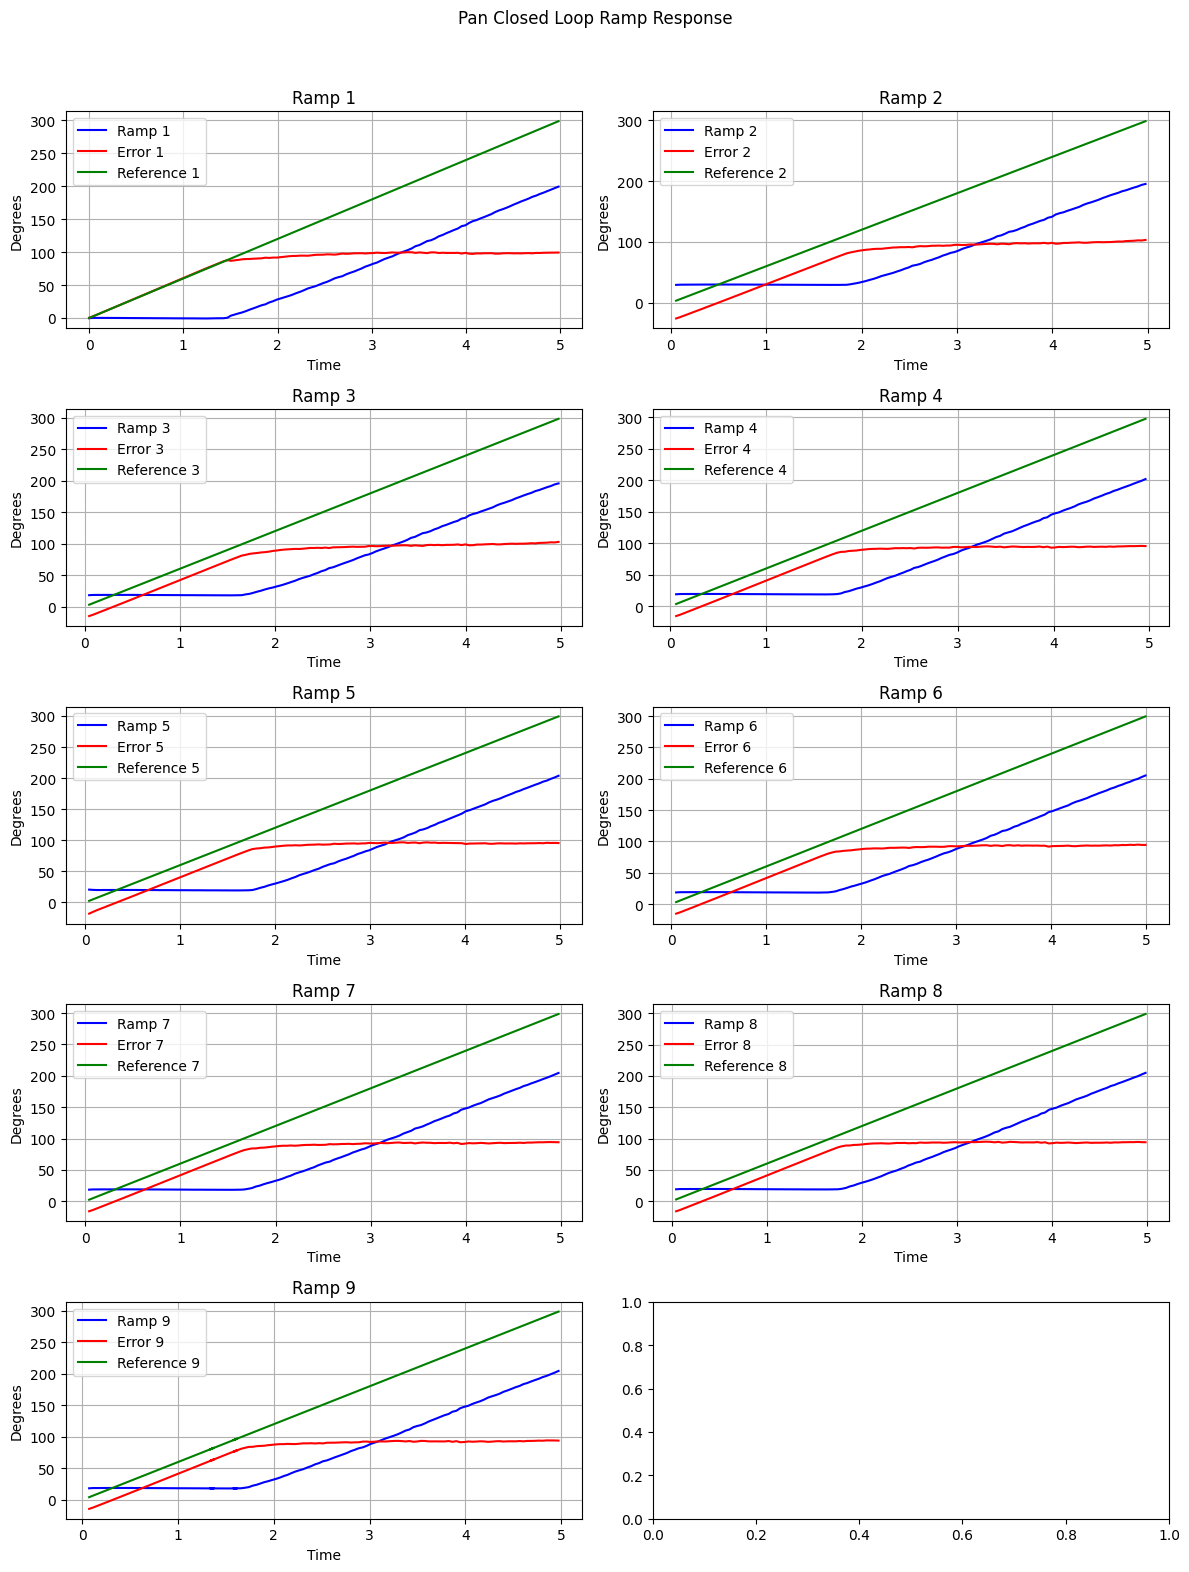

In [7]:
fig, axs = plt.subplots(5, 2, figsize=(12, 16))
fig.suptitle('Pan Closed Loop Ramp Response')

for i in range(1, 10):
    file_path = f'/home/nikolas/Documents/GitHub/Controller/logs/pan_ramp_test/{i}_ramp 2024-03-04 21_09_37.csv'
    df = pd.read_csv(file_path).query("Referencia <= 300")
    row, col = divmod(i-1, 2)

    ss_err.append(df.query("Referencia >= 100").Referencia.mean() - df.query("Referencia >= 100").Saída.mean())

    axs[row, col].plot(df['Referencia']/60, df['Saída'], c="b", label=f'Ramp {i}')
    axs[row, col].plot(df['Referencia']/60, df['Referencia']-df['Saída'], c="r", label=f"Error {i}")
    axs[row, col].plot(df['Referencia']/60, df['Referencia'], c="g", label=f"Reference {i}")
    axs[row, col].set_title(f'Ramp {i}')
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Degrees')
    axs[row, col].legend()
    axs[row, col].grid(True)

plt.tight_layout(rect=(0, 0, 1, 0.96))

plt.show()

In [8]:
ss_err = np.array(ss_err)
print(f"Ganho de malha aberta: {1/ss_err.mean()*60}")

Ganho de malha aberta: 0.6420670560880868


In [9]:
with open("../system_parameters/motor_pan.info", "w") as file:
    dump({
        "tau": tau.mean(),
        "K":1/ss_err.mean()*60
    }, file)

## Terceiro teste (degrau com controlador por avanço de fase)

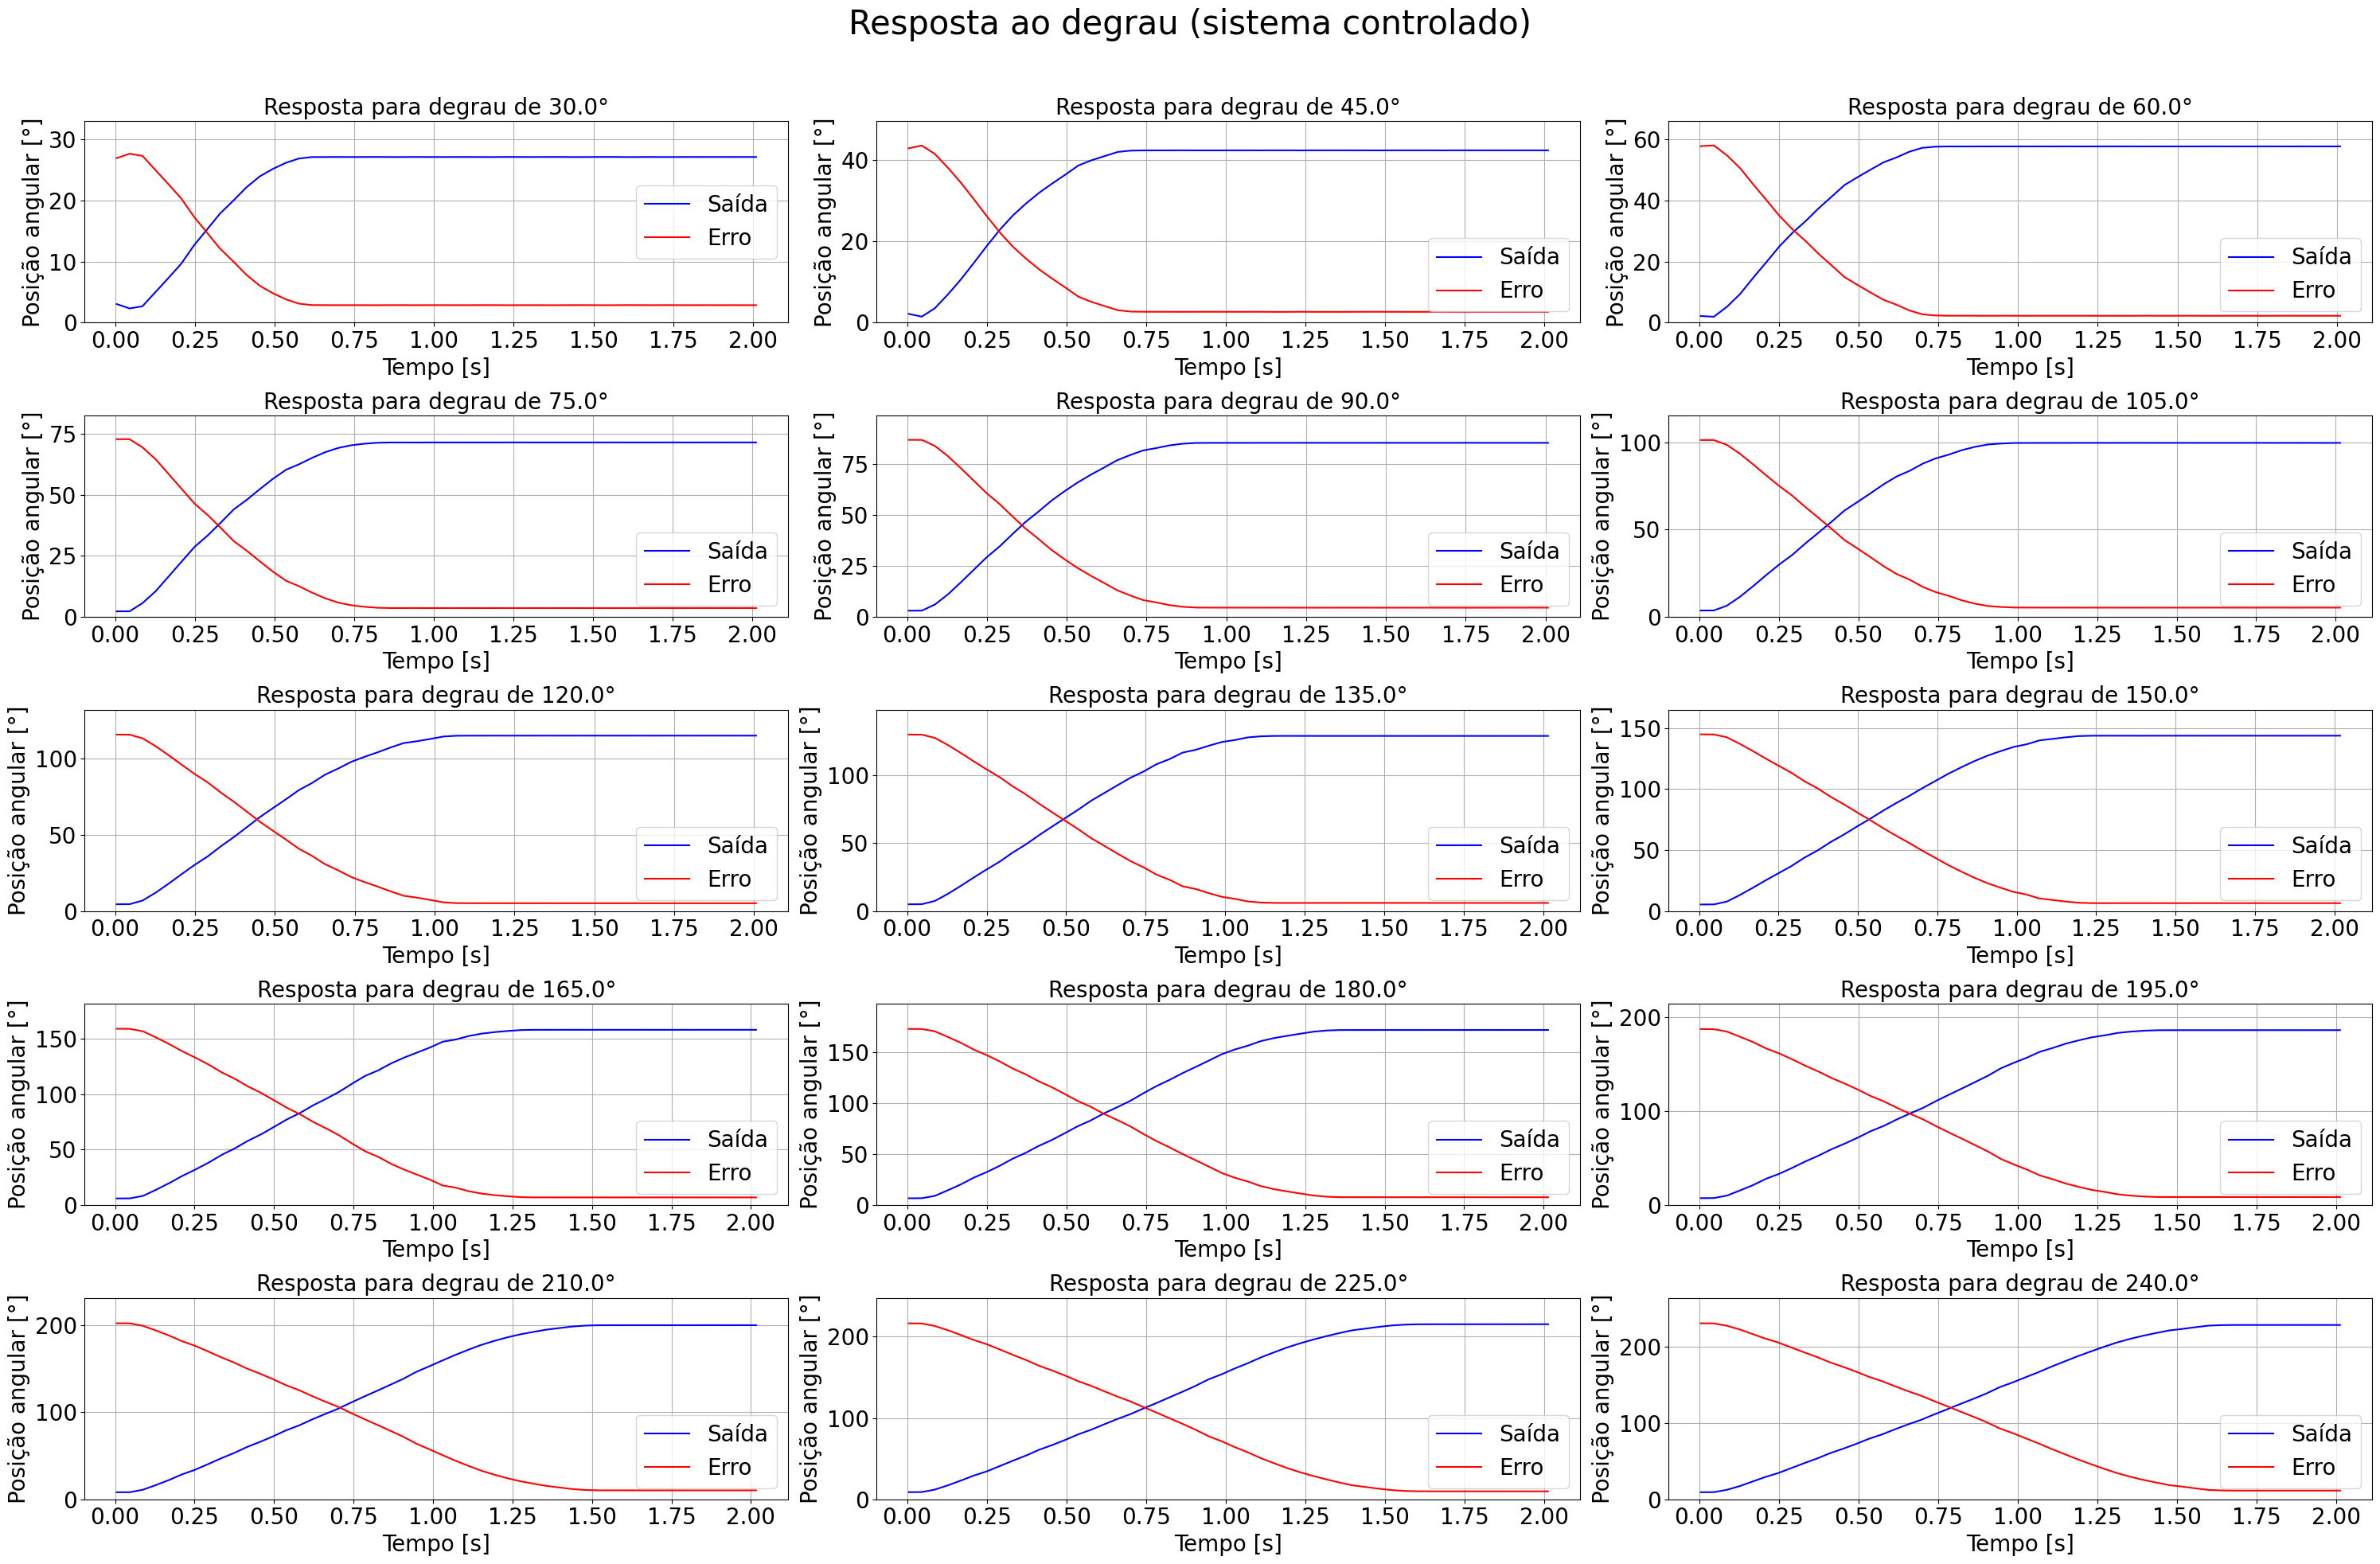

In [10]:
err = defaultdict(lambda: 0)
ss = defaultdict(lambda: 0)
ts = defaultdict(lambda: 0)
avg = {}

path = "../logs/pan_step_test/"
files = sorted(listdir(path), key=lambda x: float(x[:x.find("_")]))

for i, file in enumerate(files, start=1):
    ref = float(file[:file.find("_")])
    df = pd.read_csv(path + file)

    if ref not in avg:
        avg[ref] = df.head(50)/5
    else:
        avg[ref] += df.head(50)/5

    err[ref] += df.query("Tempo >= 1")["Erro"].mean()/5
    ss[ref] += df.query("Tempo >= 1")["Saída"].mean()/5
    ts[ref] += df.loc[np.abs((df["Saída"] - df.query("Tempo >= 1")["Saída"].mean())/df.query("Tempo >= 1")["Saída"].mean()) <= 0.02, "Tempo"].reset_index(drop=True)[0]/5


ncols = 3
fig, axs = plt.subplots(ceil(len(avg)/ncols), ncols, figsize=(30, 20))
fig.suptitle('Resposta ao degrau (sistema controlado)').set_fontsize(30)
for i, (ref, v) in enumerate(avg.items(), start=1):
    row, col = divmod(i-1, ncols)
    axs[row, col].set_title(f"Resposta para degrau de {ref}°").set_fontsize(20)
    axs[row, col].plot(v["Tempo"], v["Saída"], c="b", label=f"Saída")
    axs[row, col].plot(v["Tempo"], v["Erro"], c="r", label=f"Erro")
    axs[row, col].set_xlabel("Tempo [s]", fontsize=20)
    axs[row, col].set_ylabel("Posição angular [°]", fontsize=20)
    axs[row, col].set_ylim((min(0, v["Erro"].min()*1.1), ref*1.1))
    axs[row, col].legend(prop={"size":20})
    axs[row, col].tick_params(labelsize=20)
    axs[row, col].grid()
plt.tight_layout(rect=(0, 0, 1, 0.96))

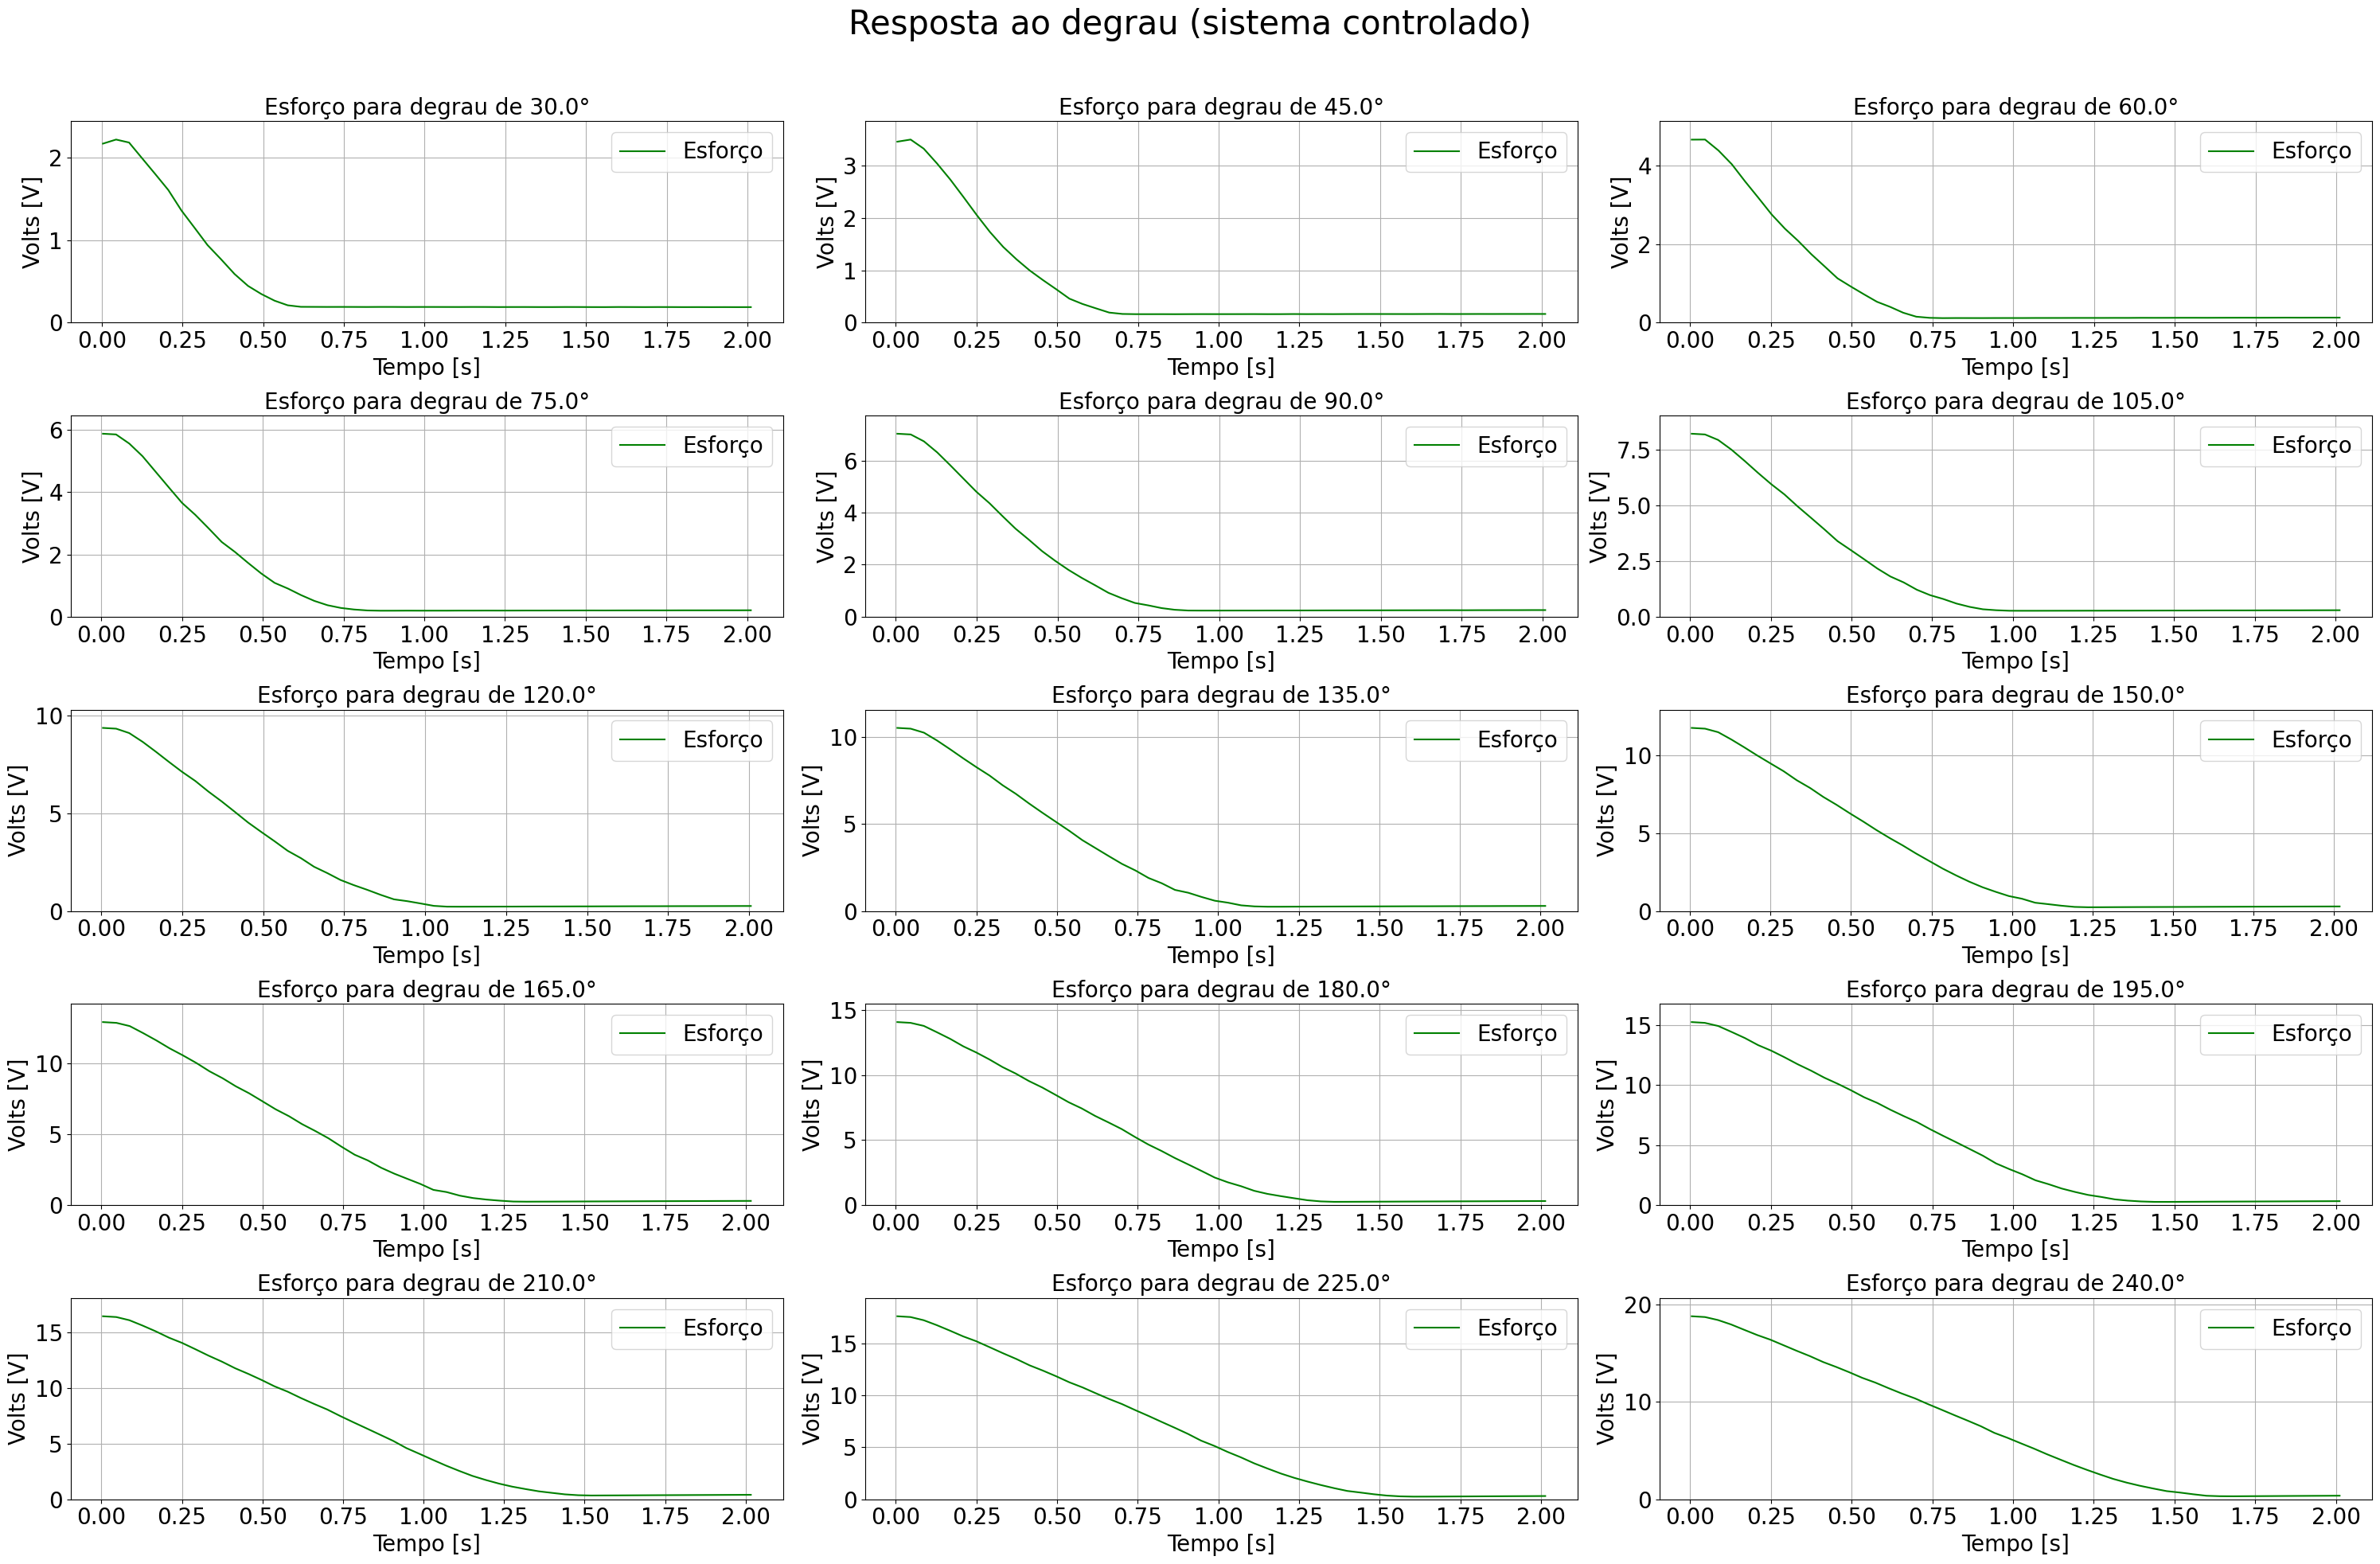

In [11]:
fig, axs = plt.subplots(ceil(len(avg)/ncols), ncols, figsize=(30, 20))
fig.suptitle('Resposta ao degrau (sistema controlado)').set_fontsize(30)
for i, (ref, v) in enumerate(avg.items(), start=1):
    row, col = divmod(i-1, ncols)
    axs[row, col].set_title(f"Esforço para degrau de {ref}°").set_fontsize(20)
    axs[row, col].plot(v["Tempo"], v["Esforço"], c="g", label=f"Esforço")
    axs[row, col].set_ylim((min(0, v["Esforço"].min()*1.1), v["Esforço"].max()*1.1))
    axs[row, col].set_xlabel("Tempo [s]", fontsize=20)
    axs[row, col].set_ylabel("Volts [V]", fontsize=20)
    axs[row, col].legend(prop={"size":20})
    axs[row, col].tick_params(labelsize=20)
    axs[row, col].grid()
plt.tight_layout(rect=(0, 0, 1, 0.96))

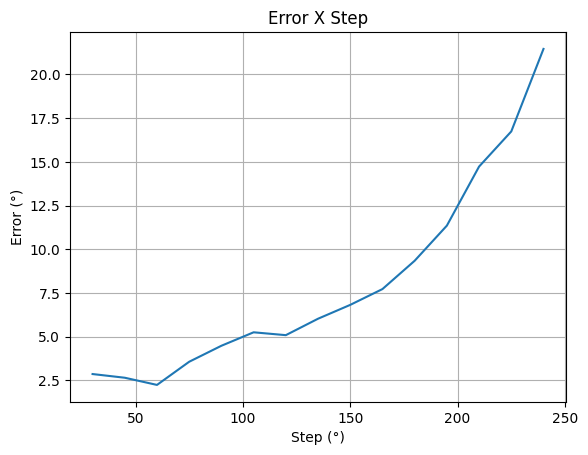

In [12]:
plt.plot(err.keys(), err.values())
plt.title("Error X Step")
plt.xlabel("Step (°)")
plt.ylabel("Error (°)")
plt.grid()
plt.show()

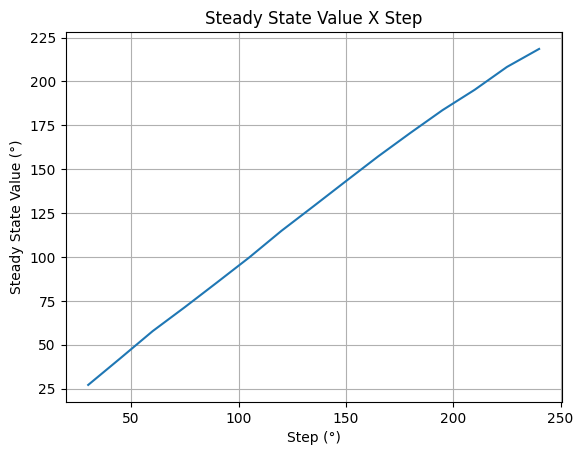

In [13]:
plt.plot(ss.keys(), ss.values())
plt.title("Steady State Value X Step")
plt.xlabel("Step (°)")
plt.ylabel("Steady State Value (°)")
plt.grid()
plt.show()

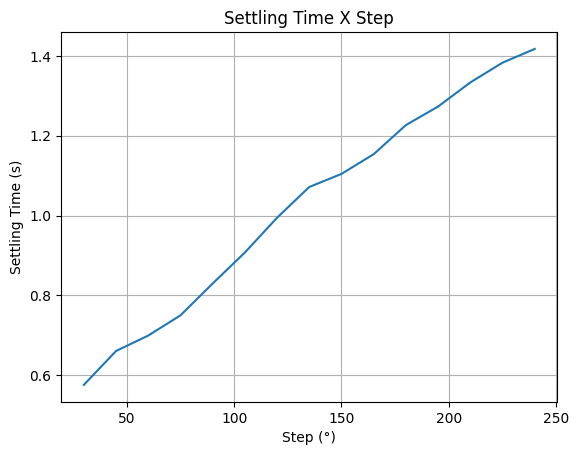

In [14]:
plt.plot(ts.keys(), ts.values())
plt.title("Settling Time X Step")
plt.xlabel("Step (°)")
plt.ylabel("Settling Time (s)")
plt.grid()
plt.show()

## Quarto teste (detecção de pose)

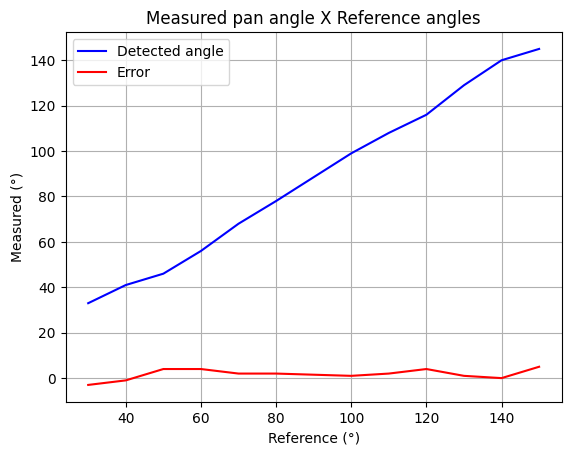

In [15]:
ref = np.array([30, 40, 50, 60, 70, 80, 100, 110, 120, 130, 140, 150])
measured = np.array([33, 41, 46, 56, 68, 78, 99, 108, 116, 129, 140, 145])
err = ref-measured

plt.plot(ref, measured, c="b", label="Detected angle")
plt.plot(ref, err, c="r", label="Error")
plt.title("Measured pan angle X Reference angles")
plt.xlabel("Reference (°)")
plt.ylabel("Measured (°)")
plt.legend()
plt.grid()
plt.show()

# Tilt

## Primeiro teste (degrau/rampa)

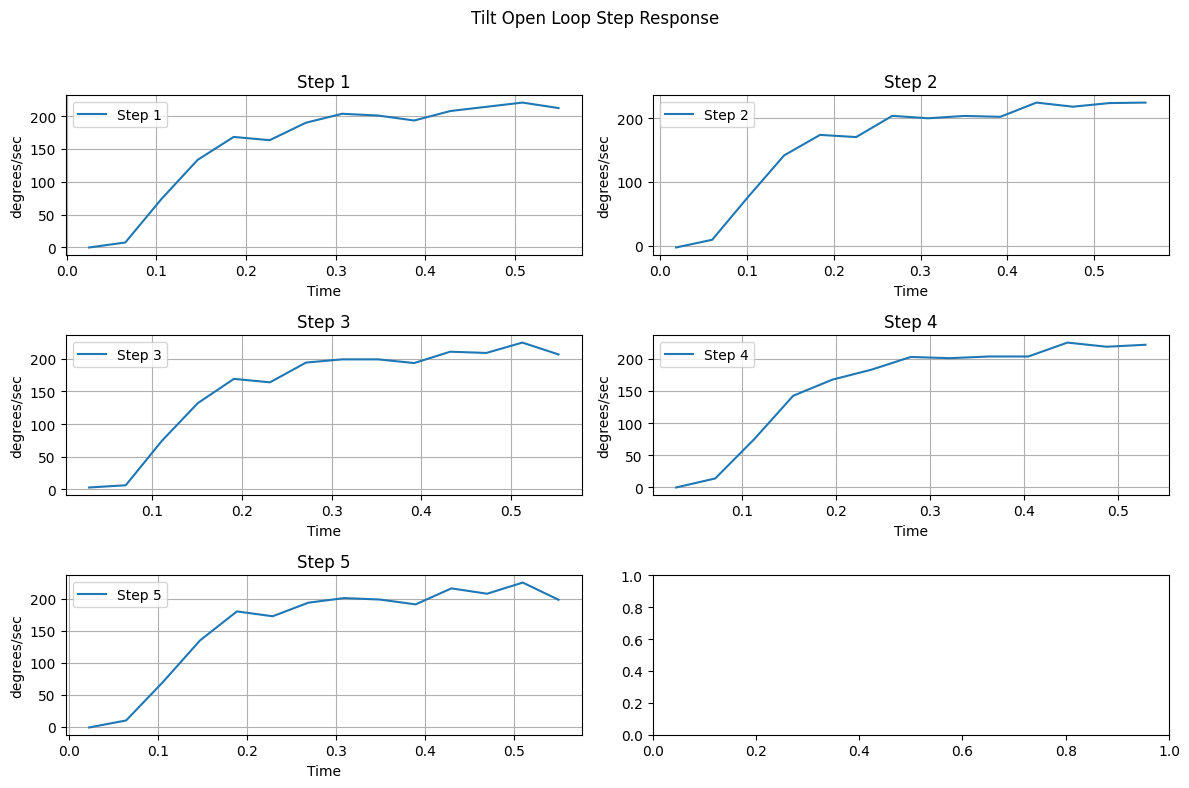

In [16]:
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
fig.suptitle('Tilt Open Loop Step Response')

for i in range(1, 6):
    file_path = f'/home/nikolas/Documents/GitHub/Controller/logs/tilt/{i}_step_open_loop TILT.csv'
    df = pd.read_csv(file_path).query("Tempo <= 0.57")
    row, col = divmod(i-1, 2)

    axs[row, col].plot(df['Tempo'], df['Saída'], label=f'Step {i}')
    axs[row, col].set_title(f'Step {i}')
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('degrees/sec')
    axs[row, col].legend()
    axs[row, col].grid(True)

plt.tight_layout(rect=(0, 0, 1, 0.96))

plt.show()

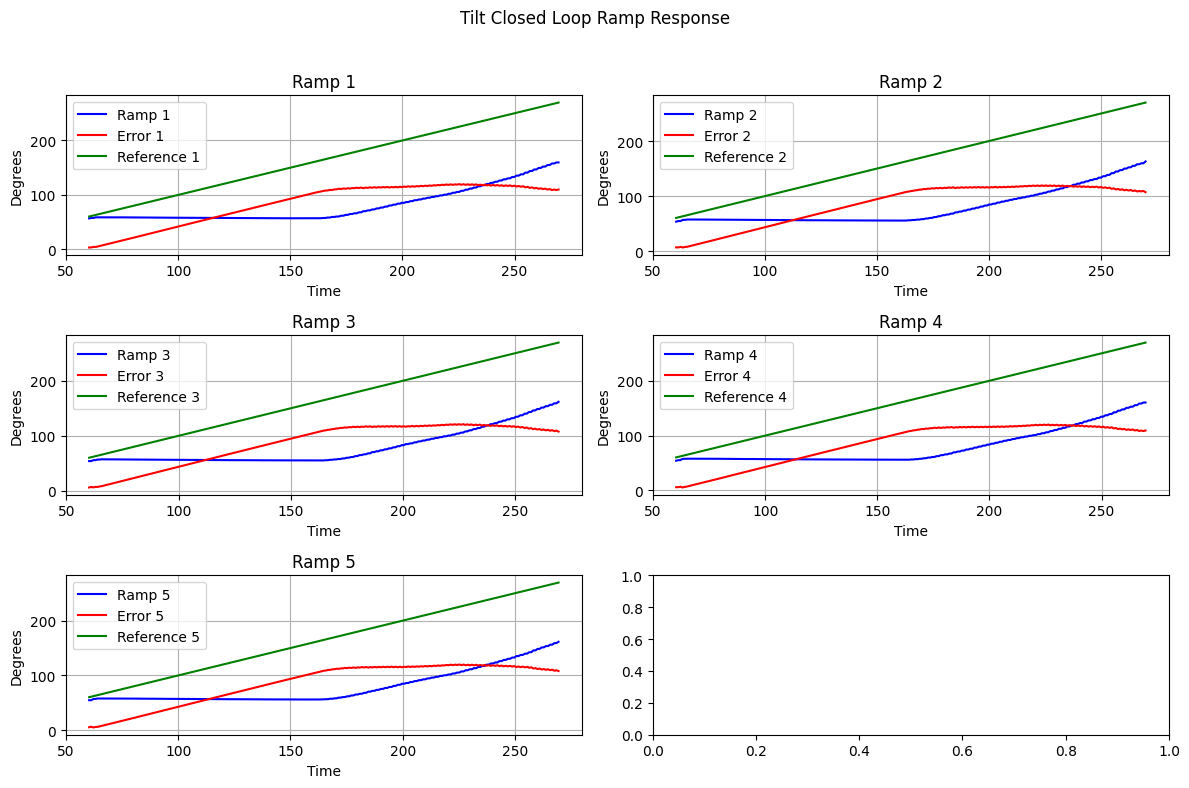

In [17]:
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
fig.suptitle('Tilt Closed Loop Ramp Response')

for i in range(1, 6):
    file_path = f'/home/nikolas/Documents/GitHub/Controller/logs/tilt/{i}_ramp_closed_loop TILT.csv'
    df = pd.read_csv(file_path).query("Referencia <= 270")
    row, col = divmod(i-1, 2)

    axs[row, col].plot(df['Referencia'], df['Saída'], c="b", label=f'Ramp {i}')
    axs[row, col].plot(df['Referencia'], df['Erro'], c="r", label=f"Error {i}")
    axs[row, col].plot(df['Referencia'], df['Referencia'], c="g", label=f"Reference {i}")
    axs[row, col].set_title(f'Ramp {i}')
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Degrees')
    axs[row, col].legend()
    axs[row, col].grid(True)

plt.tight_layout(rect=(0, 0, 1, 0.96))

plt.show()

## Segundo teste (degrau/rampa)

In [18]:
tau, ss_err = [], []

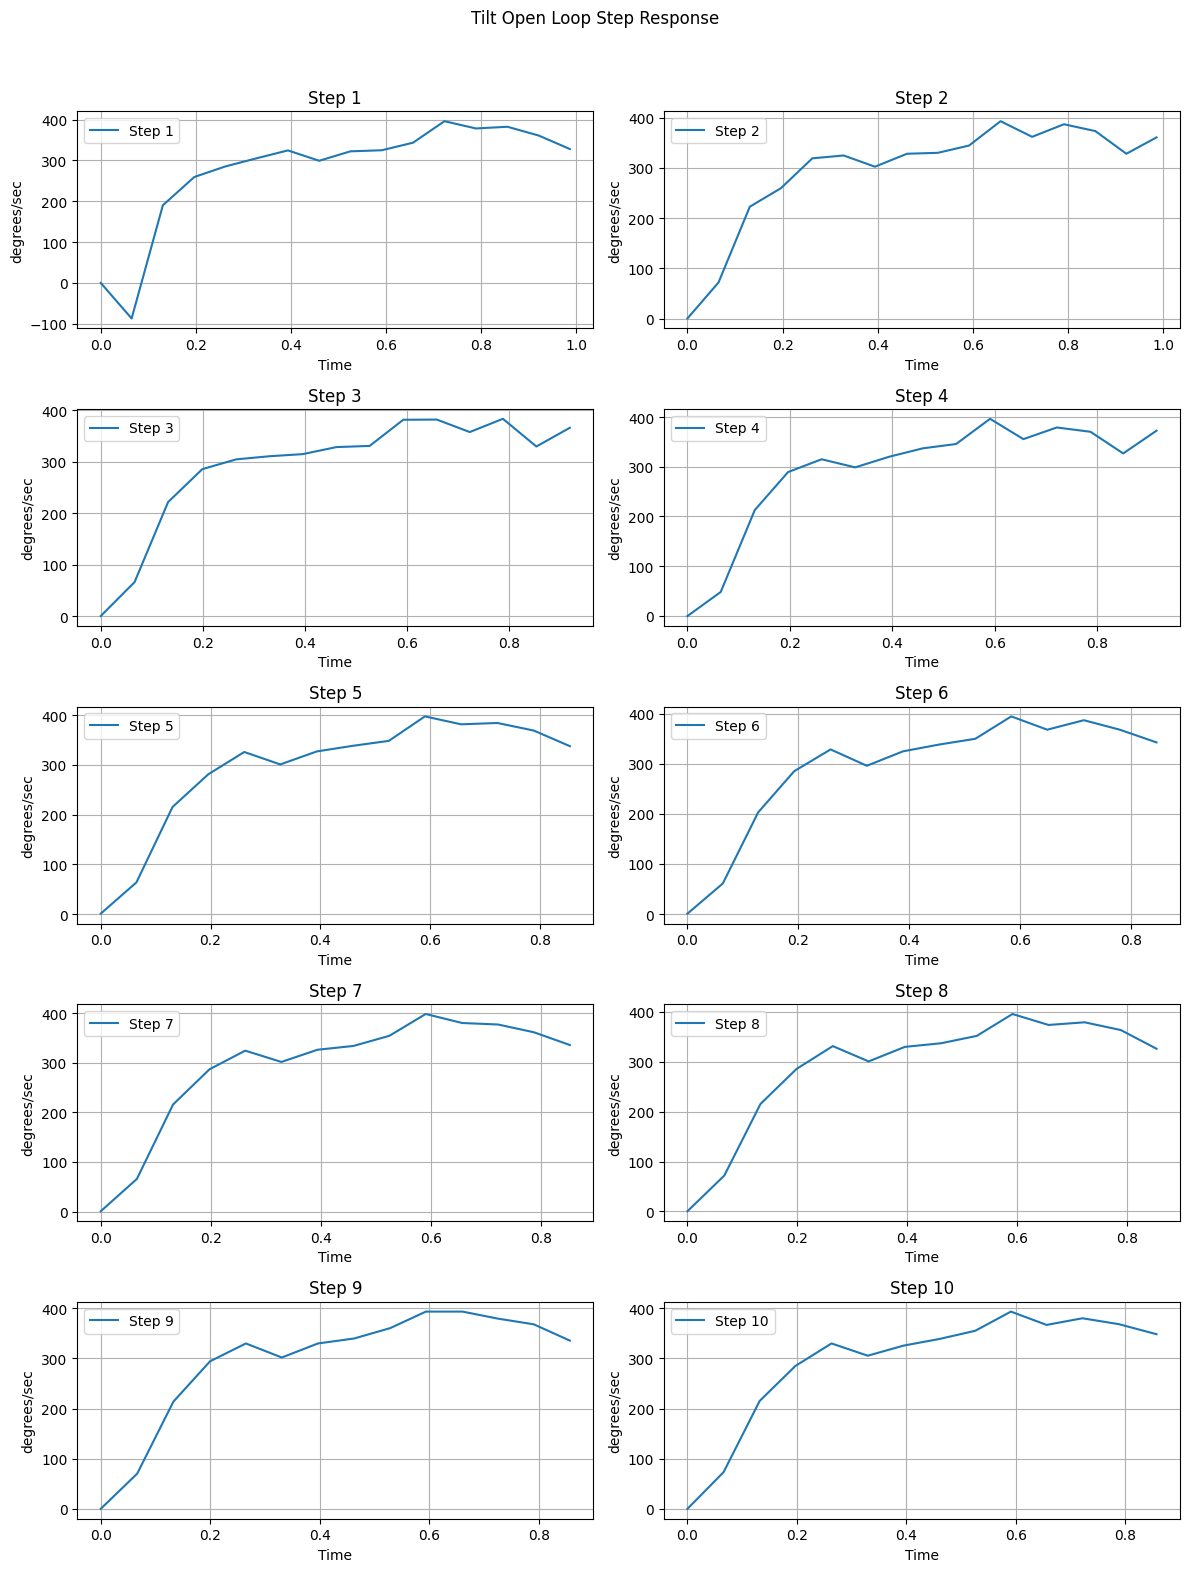

In [19]:
fig, axs = plt.subplots(5, 2, figsize=(12, 16))
fig.suptitle('Tilt Open Loop Step Response')

for i in range(1, 11):
    file_path = f'/home/nikolas/Documents/GitHub/Controller/logs/tilt_step_open_loop_test/{i}_step_open_loop 2024-03-04 21_03_50.csv'
    df = pd.read_csv(file_path)
    row, col = divmod(i-1, 2)

    ss_speed = df.query("Tempo >= 0.4").Saída.mean()
    y = df.loc[df["Tempo"] <= 0.2, "Saída"]
    x = df.loc[df["Tempo"] <= 0.2, "Tempo"]
    tau.append(lerp(y, x)(0.63*ss_speed))

    axs[row, col].plot(df['Tempo'], df['Saída'], label=f'Step {i}')
    axs[row, col].set_title(f'Step {i}')
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('degrees/sec')
    axs[row, col].legend()
    axs[row, col].grid(True)

plt.tight_layout(rect=(0, 0, 1, 0.96))

plt.show()

In [20]:
tau = np.array(tau)
print(f"Constante de tempo: {tau.mean()}s")

Constante de tempo: 0.1446449747240282s


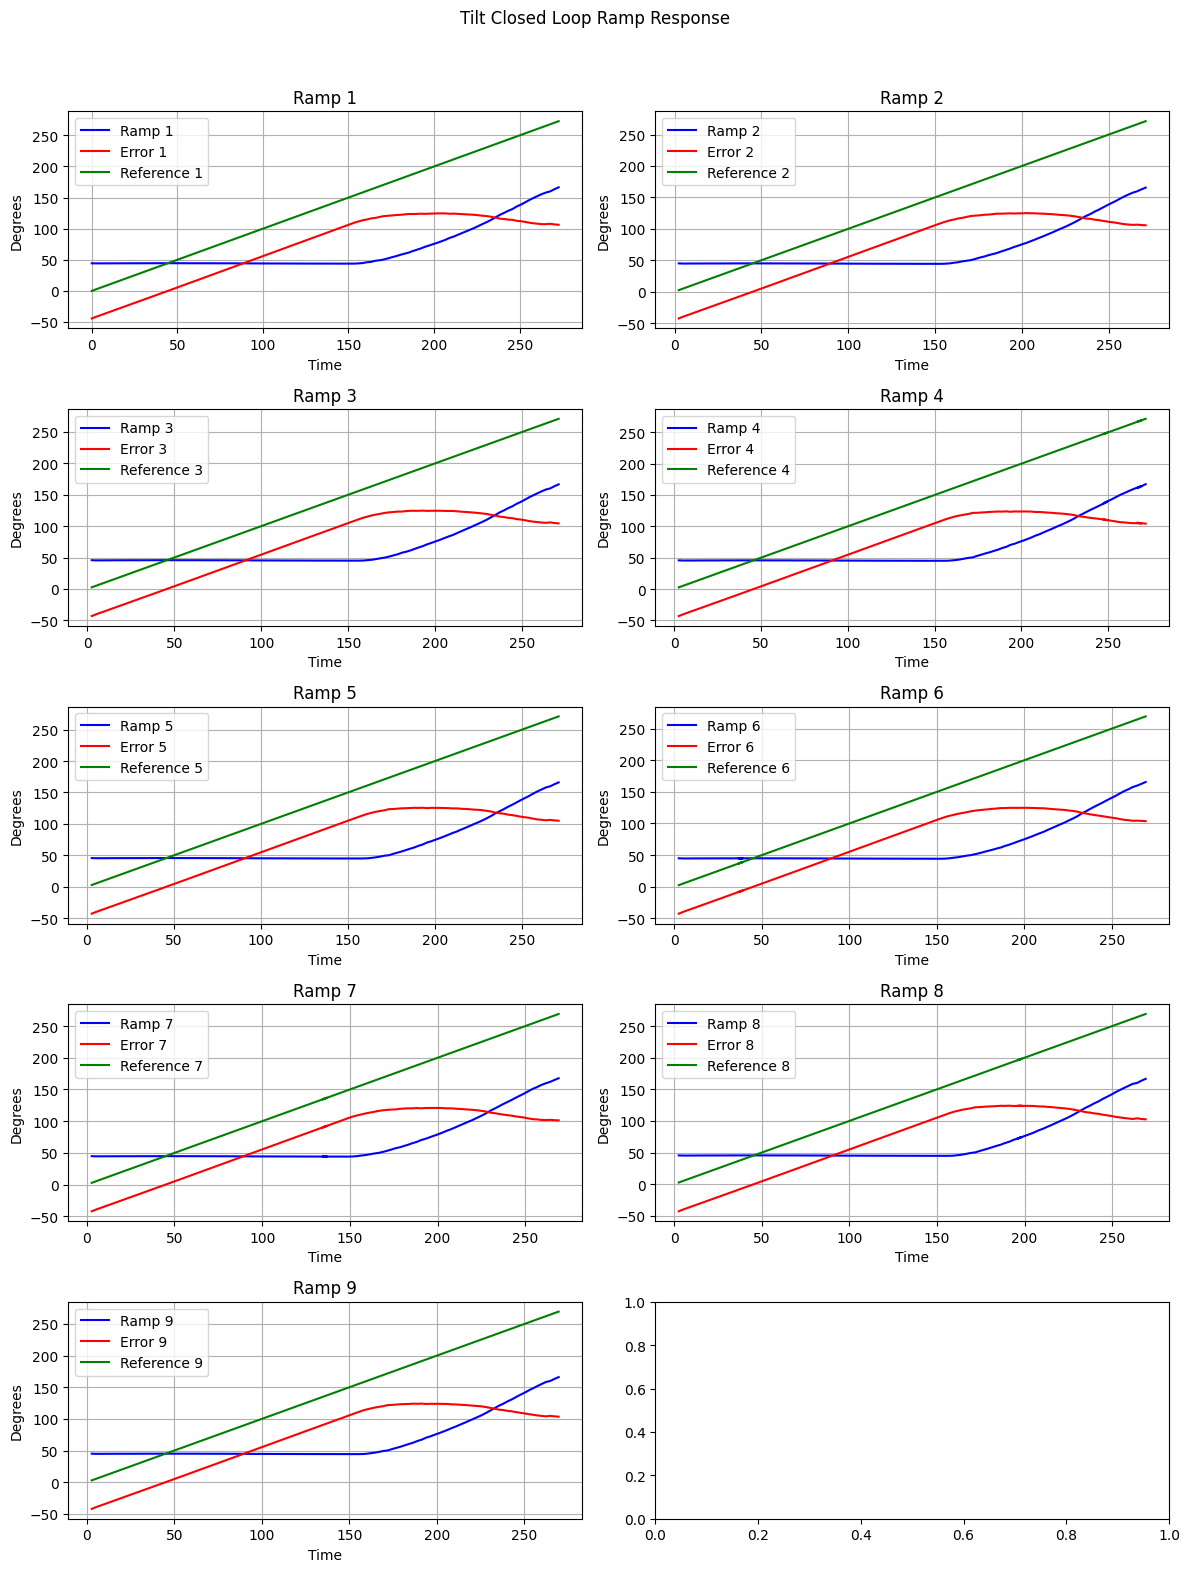

In [21]:
fig, axs = plt.subplots(5, 2, figsize=(12, 16))
fig.suptitle('Tilt Closed Loop Ramp Response')

for i in range(1, 10):
    file_path = f'/home/nikolas/Documents/GitHub/Controller/logs/tilt_ramp_test/{i}_ramp 2024-03-04 21_07_52.csv'
    df = pd.read_csv(file_path)
    row, col = divmod(i-1, 2)

    ss_err.append(df.query("Referencia >= 175").Referencia.mean() - df.query("Referencia >= 175").Saída.mean())

    axs[row, col].plot(df['Referencia'], df['Saída'], c="b", label=f'Ramp {i}')
    axs[row, col].plot(df['Referencia'], df['Referencia']-df['Saída'], c="r", label=f"Error {i}")
    axs[row, col].plot(df['Referencia'], df['Referencia'], c="g", label=f"Reference {i}")
    axs[row, col].set_title(f'Ramp {i}')
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Degrees')
    axs[row, col].legend()
    axs[row, col].grid(True)

plt.tight_layout(rect=(0, 0, 1, 0.96))

plt.show()

In [22]:
ss_err = np.array(ss_err)
print(f"Ganho de malha aberta: {1/ss_err.mean()*60}")

Ganho de malha aberta: 0.5124565903970256


In [23]:
with open("../system_parameters/motor_tilt.info", "w") as file:
    dump({
        "tau": tau.mean(),
        "K":1/ss_err.mean()*60
    }, file)

## Terceiro teste (degrau com controlador por avanço de fase)

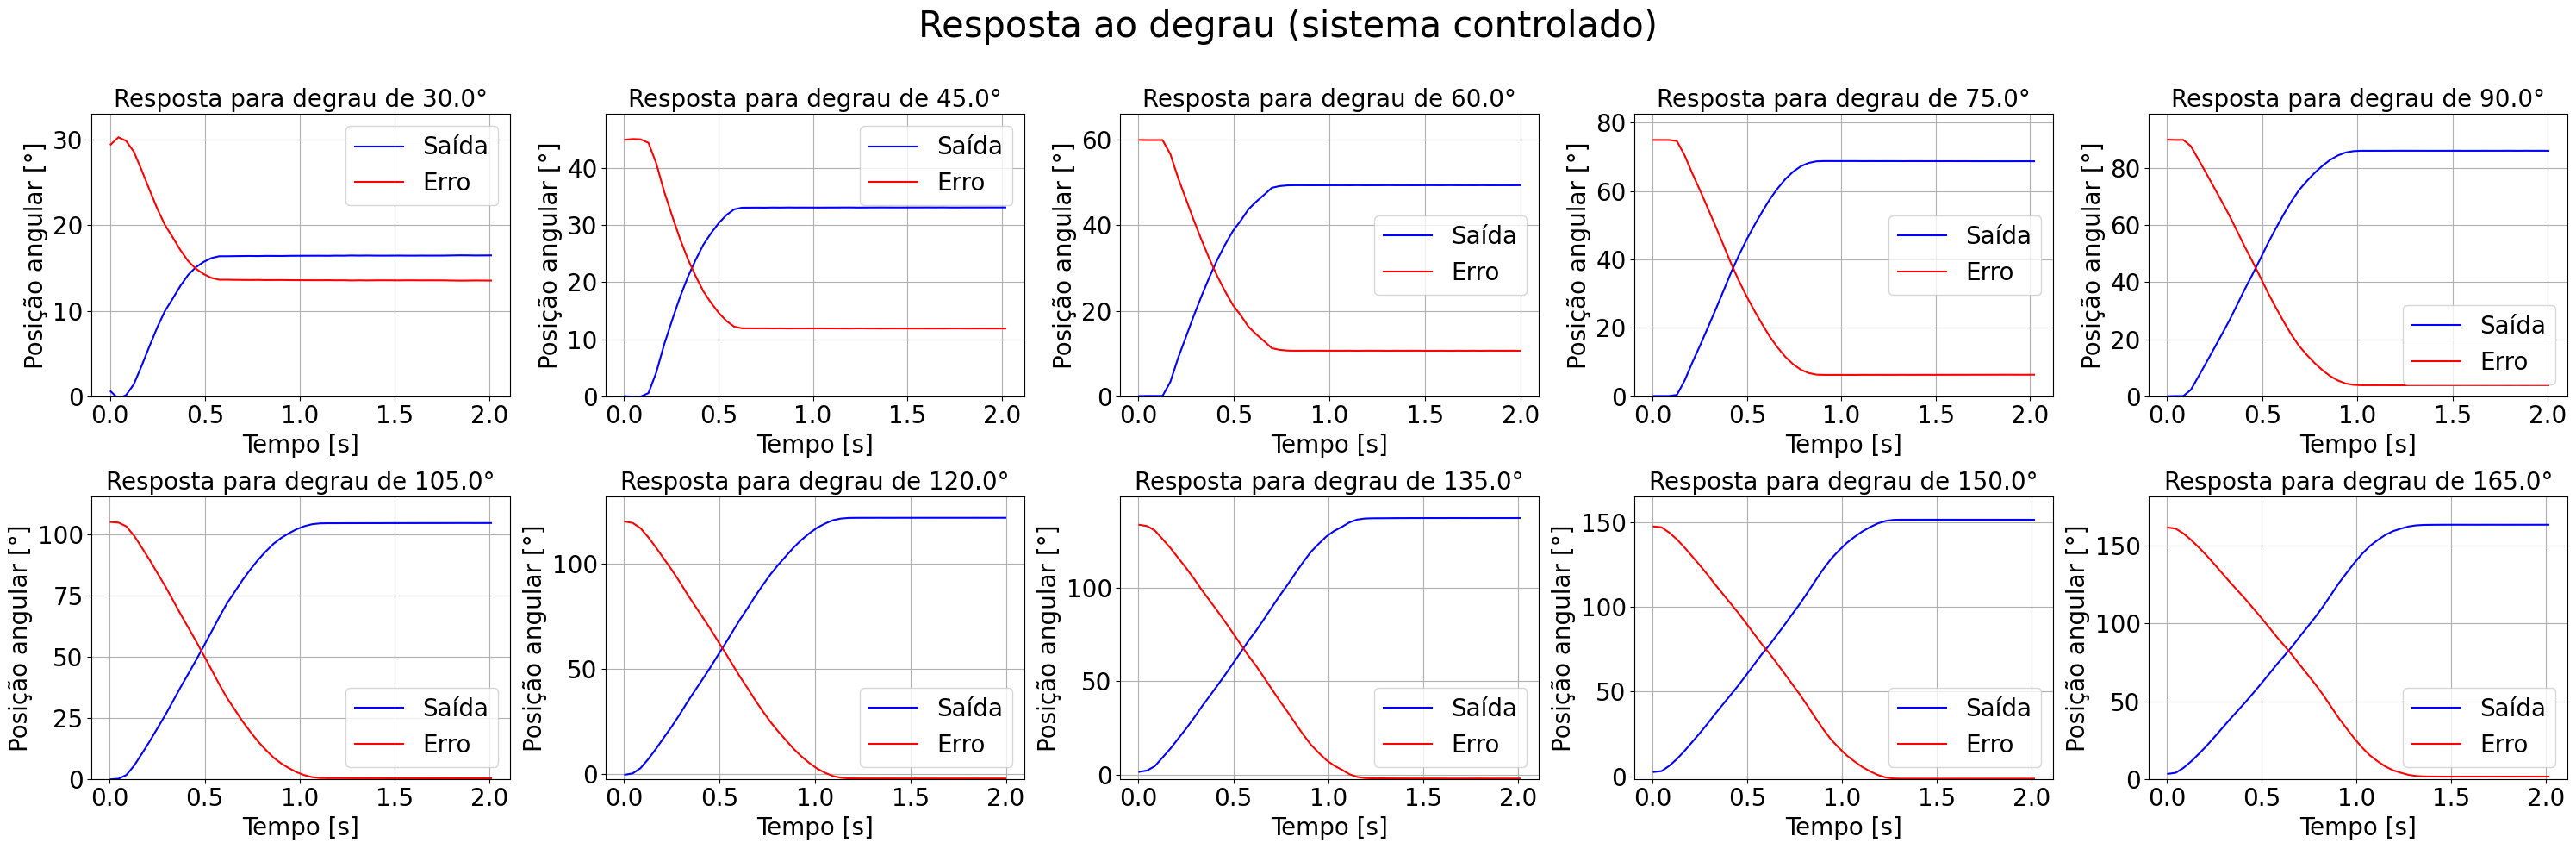

In [24]:
err = defaultdict(lambda: 0)
ss = defaultdict(lambda: 0)
ts = defaultdict(lambda: 0)
avg = {}

path = "../logs/tilt_step_test/"
files = sorted(listdir(path), key=lambda x: float(x[:x.find("_")]))

for i, file in enumerate(files, start=1):
    ref = float(file[:file.find("_")])
    df = pd.read_csv(path + file)

    if ref not in avg:
        avg[ref] = df.head(50)/5
    else:
        avg[ref] += df.head(50)/5

    err[ref] += df.query("Tempo >= 1")["Erro"].mean()/5
    ss[ref] += df.query("Tempo >= 1")["Saída"].mean()/5
    ts[ref] += df.loc[np.abs((df["Saída"] - df.query("Tempo >= 1")["Saída"].mean())/df.query("Tempo >= 1")["Saída"].mean()) <= 0.02, "Tempo"].reset_index(drop=True)[0]/5


ncols = 5
fig, axs = plt.subplots(ceil(len(avg)/ncols), ncols, figsize=(30, 10))
fig.suptitle('Resposta ao degrau (sistema controlado)').set_fontsize(30)
for i, (ref, v) in enumerate(avg.items(), start=1):
    row, col = divmod(i-1, ncols)
    axs[row, col].set_title(f"Resposta para degrau de {ref}°").set_fontsize(20)
    axs[row, col].plot(v["Tempo"], v["Saída"], c="b", label=f"Saída")
    axs[row, col].plot(v["Tempo"], v["Erro"], c="r", label=f"Erro")
    axs[row, col].set_ylim((min(0, v["Erro"].min()*1.1), ref*1.1))
    axs[row, col].set_xlabel("Tempo [s]", fontsize=20)
    axs[row, col].set_ylabel("Posição angular [°]", fontsize=20)
    axs[row, col].legend(prop={"size":20})
    axs[row, col].tick_params(labelsize=20)
    axs[row, col].grid()
plt.tight_layout(rect=(0, 0, 1, 0.96))

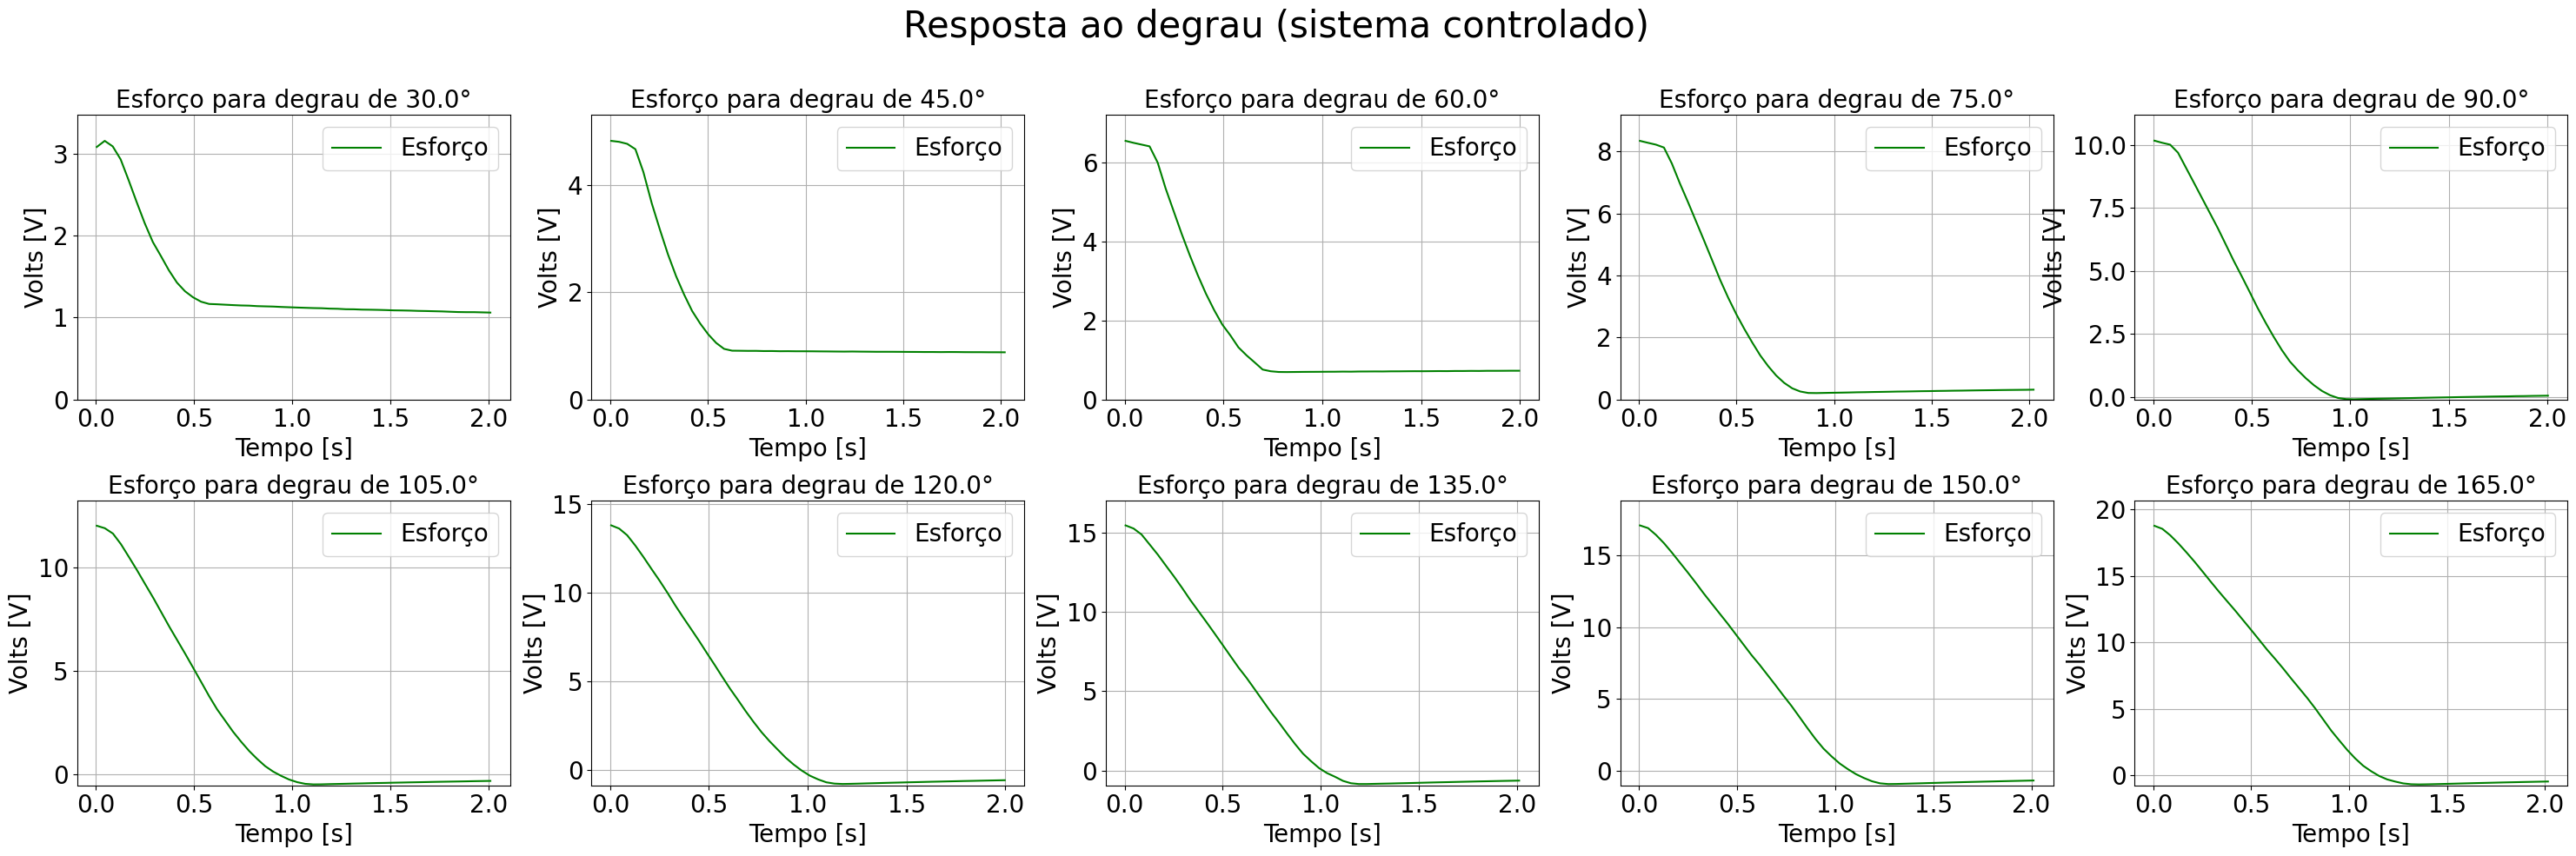

In [25]:
fig, axs = plt.subplots(ceil(len(avg)/ncols), ncols, figsize=(30, 10))
fig.suptitle('Resposta ao degrau (sistema controlado)').set_fontsize(30)
for i, (ref, v) in enumerate(avg.items(), start=1):
    row, col = divmod(i-1, ncols)
    axs[row, col].set_title(f"Esforço para degrau de {ref}°").set_fontsize(20)
    axs[row, col].plot(v["Tempo"], v["Esforço"], c="g", label=f"Esforço")
    axs[row, col].set_ylim((min(0, v["Esforço"].min()*1.1), v["Esforço"].max()*1.1))
    axs[row, col].set_xlabel("Tempo [s]", fontsize=20)
    axs[row, col].set_ylabel("Volts [V]", fontsize=20)
    axs[row, col].legend(prop={"size":20})
    axs[row, col].tick_params(labelsize=20)
    axs[row, col].grid()
plt.tight_layout(rect=(0, 0, 1, 0.96))

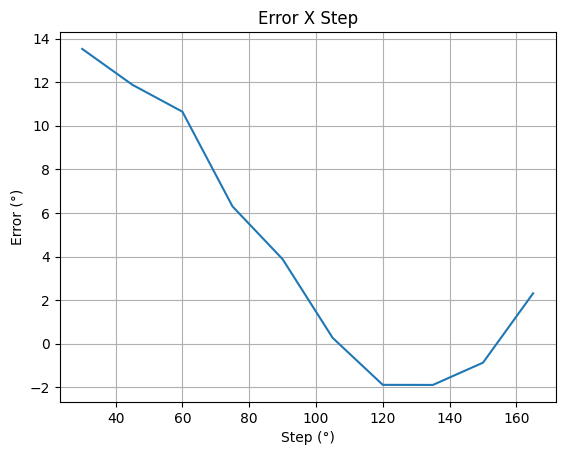

In [26]:
plt.plot(err.keys(), err.values())
plt.title("Error X Step")
plt.xlabel("Step (°)")
plt.ylabel("Error (°)")
plt.grid()
plt.show()

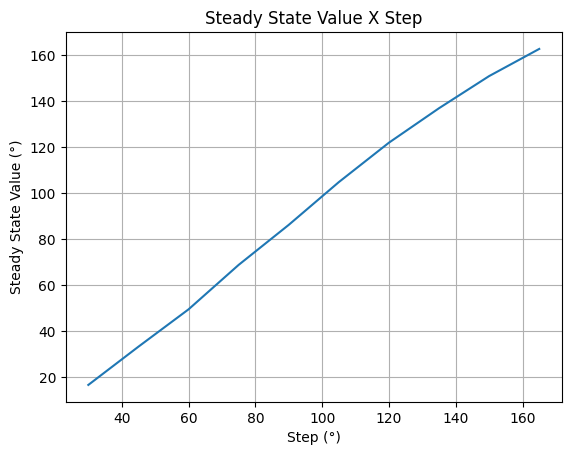

In [27]:
plt.plot(ss.keys(), ss.values())
plt.title("Steady State Value X Step")
plt.xlabel("Step (°)")
plt.ylabel("Steady State Value (°)")
plt.grid()
plt.show()

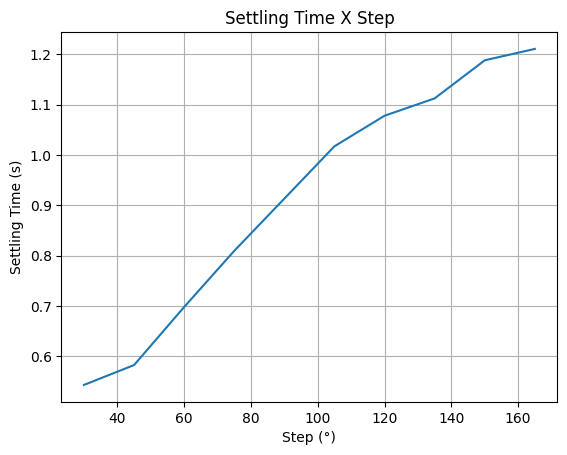

In [28]:
plt.plot(ts.keys(), ts.values())
plt.title("Settling Time X Step")
plt.xlabel("Step (°)")
plt.ylabel("Settling Time (s)")
plt.grid()
plt.show()